In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from utils.load_data import load_behavioral_data
%load_ext rpy2.ipython

##### Load the data
Remove RT outliers (defined as any response time less than 0.2 seconds). This also eliminates the trials where the subject did not respond.

In [3]:
data = load_behavioral_data(min_RT = 0.2)

In [4]:
print("High reward mean acceptance rate:", data.query("condition == 'equalIndifference'")["accept"].mean())
print("Low reward mean acceptance rate:", data.query("condition == 'equalRange'")["accept"].mean())

High reward mean acceptance rate: 0.65746339331245
Low reward mean acceptance rate: 0.45013123359580054


### Analysis of acceptance rate
**Question: How does gain and loss affect acceptance rate? Does it change based on the condition?**

Model 1: Predict acceptance rate as a function of condition, gain and loss

In [36]:
%%R -i data
library(lme4)
library(lmerTest)

/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/.venv/lib/python3.12/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In [37]:
%%R
model1 <- glmer(accept ~ condition*gain + condition*loss + (1|sub), data=data, family=binomial)
summary(model1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: accept ~ condition * gain + condition * loss + (1 | sub)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 15626.8  15684.4  -7806.4  15612.8    27436 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-188.535   -0.237    0.028    0.258   63.728 

Random effects:
 Groups Name        Variance Std.Dev.
 sub    (Intercept) 3.172    1.781   
Number of obs: 27443, groups:  sub, 108

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               0.318584   0.265176   1.201   0.2296    
conditionequalRange      -0.843328   0.371904  -2.268   0.0234 *  
gain                      0.292966   0.005767  50.799  < 2e-16 ***
loss                     -0.467691   0.010033 -46.615  < 2e-16 ***
conditionequalRange:gain  0.235372   0.011609  20.276  < 2e-16 ***
conditionequalRange:loss -0.064168   0.01

In [38]:
%%R
# Model comparison 
model2 <- glmer(accept ~ condition + gain + loss + (1|sub), data=data, family=binomial)
anova(model1, model2)

Data: data
Models:
model2: accept ~ condition + gain + loss + (1 | sub)
model1: accept ~ condition * gain + condition * loss + (1 | sub)
       npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)    
model2    5 16271 16312 -8130.3    16261                         
model1    7 15627 15684 -7806.4    15613 647.79  2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


**Findings:**
1. No significant effect of condition on acceptance rate
2. For the high reward condition, there is a significant effect of gain on acceptance rate.
    * Log-odds increases by 0.321 (w/ all participants, its 0.293)
3. For the low reward condition, there is a significant effect of gain on acceptance rate.
    * Log-odds increases by 0.707 (w/ all participants, its 0.528)
4. For the high reward condition, there is a significant effect of loss on acceptance rate.
    * Log-odds decreases by 0.476 (w/ all participants, its 0.468)
5. For the low reward condition, there is a significant effect of loss on acceptance rate.
    * Log-odds decreases by 0.683 (w/ all participants, its 0.532)

For high reward, the ratio for loss/gain is 0.476/0.321 = 1.483 (loss averse behavior, w/ all participants its 1.802). For low reward, the ratio for loss/gain is 0.683/0.707 = 0.966 (not loss averse, w/ all participants its 1.151).

After model comparison, we find that gain and loss interact with the condition. 

### Analysis of response time
**Question: What are the differences in response time between conditions? Are acceptances faster than rejections between conditions?**

Model 2: Predict response time as a function of condition, gain, loss, distance from indifference and response.


In [54]:
equalIndiff_rows = data["condition"] == "equalIndifference"
data.loc[equalIndiff_rows, "dist_from_indiff"] = np.abs(data[equalIndiff_rows]["gain"] - 1.8*data[equalIndiff_rows]["loss"]) / np.square(1 + 1.8**2)
equalRange_rows = data["condition"] == "equalRange"
data.loc[equalRange_rows, "dist_from_indiff"] = np.abs(data[equalRange_rows]["gain"] - 1.2*data[equalRange_rows]["loss"]) / np.square(1 + 1.2**2)

In [58]:
%%R -i data
# Is there an effect of accepting on response time between conditions? And if so, is this due to the gain and loss?
# Model 2: Predict Response Time as a function of condition, gain, loss, distance from indifference and response.
model3 <- lmer(RT ~ gain*condition + loss*condition + dist_from_indiff*condition + (1|sub), data=data)
summary(model3)

/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/.venv/lib/python3.12/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ gain * condition + loss * condition + dist_from_indiff *  
    condition + (1 | sub)
   Data: data

REML criterion at convergence: 39726.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7465 -0.6692 -0.1583  0.5099  5.3958 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.1058   0.3253  
 Residual             0.2438   0.4938  
Number of obs: 27443, groups:  sub, 108

Fixed effects:
                                       Estimate Std. Error         df t value
(Intercept)                           1.767e+00  4.768e-02  1.400e+02  37.058
gain                                 -2.495e-03  4.684e-04  2.733e+04  -5.327
conditionequalRange                  -1.515e-01  6.740e-02  1.398e+02  -2.248
loss                                  1.559e-02  9.296e-04  2.733e+04  16.774
dist_from_indiff                     -3.676e-01  1.080e-02  2.733e+04 -34.02

In [59]:
%%R
# Post-hoc tests for condition equalRange (low reward)
model4 <- lmer(RT ~ gain + loss + dist_from_indiff + accept + (1 + accept |sub), data=data[data$condition == 'equalRange', ])
summary(model4)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ gain + loss + dist_from_indiff + accept + (1 + accept |      sub)
   Data: data[data$condition == "equalRange", ]

REML criterion at convergence: 18295.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5492 -0.6546 -0.1595  0.4885  5.8909 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 sub      (Intercept) 0.12975  0.3602        
          accept      0.06179  0.2486   -0.51
 Residual             0.21512  0.4638        
Number of obs: 13716, groups:  sub, 54

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)       1.654e+00  5.206e-02  6.575e+01  31.773  < 2e-16 ***
gain             -4.054e-03  1.125e-03  1.367e+04  -3.603 0.000316 ***
loss              1.670e-02  1.158e-03  1.366e+04  14.417  < 2e-16 ***
dist_from_indiff -1.742e-01  6.168e-03  1.366e+04 -28.248  < 2e-16 ***
accept           -3.303e-03  3.59

In [63]:
%%R
# Post-hoc tests for condition equalIndifference (high reward)
model5 <- lmer(RT ~ gain + loss + dist_from_indiff + accept + (1 + accept|sub), data=data[data$condition == 'equalIndifference', ])
summary(model5)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RT ~ gain + loss + dist_from_indiff + accept + (1 + accept |      sub)
   Data: data[data$condition == "equalIndifference", ]

REML criterion at convergence: 20072.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6410 -0.6666 -0.1530  0.4902  5.3207 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 sub      (Intercept) 0.11486  0.3389        
          accept      0.09832  0.3136   -0.36
 Residual             0.24453  0.4945        
Number of obs: 13727, groups:  sub, 54

Fixed effects:
                   Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)       1.885e+00  5.035e-02  7.058e+01  37.439   <2e-16 ***
gain              6.103e-04  6.087e-04  1.367e+04   1.003   0.3160    
loss              1.215e-02  1.101e-03  1.366e+04  11.030   <2e-16 ***
dist_from_indiff -4.454e-01  1.165e-02  1.366e+04 -38.246   <2e-16 ***
accept           -1.006e-0

**Findings:**
1. Condition has no significant effect on response time.
2. In high reward condition, there is a significant effect of gain on response time.
    * Beta of 0.021 (0.023 w/ all participants)
3. In low reward condition, there is a significant effect of gain on response time.
    * Beta of 0.001 (0.003 w/ all participants)
    * This is slightly significant after post-hoc analysis. 
4. In high reward condition, there is not a significant effect of loss on response time.
5. In low reward condition, there is a significant effect of loss on response time.
    * Beta of 0.009
6. In high reward condition, there is a significant effect of distance from indifference on response time.
    * Beta of -0.05
7. In low reward condition, there is not a significant effect of distance from indifference on response time.
    * Beta of -0.03
8. In high reward condition, there is a significant effect of accepting on response time.
    * Beta of 0.098
9. In low reward condition, there is a significant effect of accepting on response time.
    * Beta of -0.01
    * This is not significant after post-hoc analysis. 

For the high reward condition, increasing gains make people respond faster, while increasing losses has no effect. In the low reward condition, this effect is reversed: increasing gains causes no effect on response time, while increasing losses makes people respond faster.

For both conditions, the distance from indifference makes response times faster (the high reward condition is a little more pronounced). 

Finally, accept trials are slower than reject trials in the high reward condition, but not in the low reward condition. This effect is not due to the gains, losses or distance from indifference seen in the trials. 

### Visualization of response times: 

**TODO**: We might need to adjust the distance from indifference for the high reward condition, since this might be different from the low reward condition. Notice in the plot below, rejections look slower than acceptances, but the opposite is true in our model. 


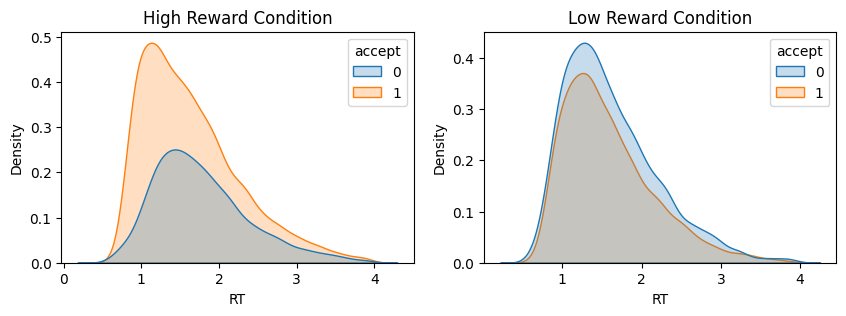

In [69]:
# For each condition, do a histogram of RT based on accept
# Figure with two subplots, one for each condition
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
sns.kdeplot(data=data.query('condition == "equalIndifference"'), fill = True, x='RT', hue='accept', ax=axs[0])
sns.kdeplot(data=data.query('condition == "equalRange"'), fill = True, x='RT', hue='accept', ax=axs[1]) 
axs[0].set_title('High Reward Condition')
axs[1].set_title('Low Reward Condition')
plt.show()


### Visualization of acceptance rate

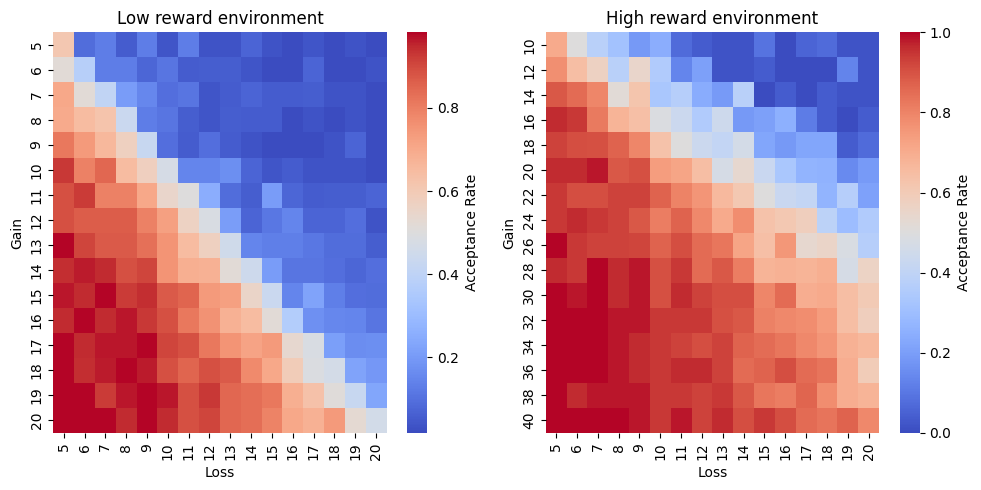

In [6]:
# Two figures: Acceptance rate per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = data.query("condition == 'equalRange'").groupby(['gain', 'loss'])['accept'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Acceptance Rate'}, ax = axs[0])
axs[0].set_title("Low reward environment")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = data.query("condition == 'equalIndifference'").groupby(['gain', 'loss'])['accept'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Acceptance Rate'}, ax = axs[1])
axs[1].set_title("High reward environment")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()

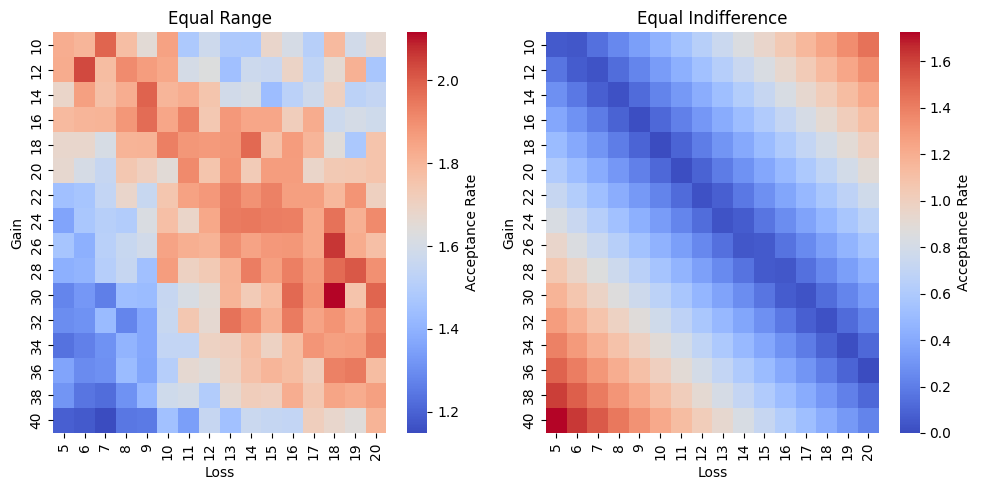

In [57]:
# Two figures: Acceptance rate per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = data.query("condition == 'equalIndifference'").groupby(['gain', 'loss'])['RT'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Acceptance Rate'}, ax = axs[0])
axs[0].set_title("Equal Range")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = data.query("condition == 'equalIndifference'").groupby(['gain', 'loss'])['dist_from_indiff'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Acceptance Rate'}, ax = axs[1])
axs[1].set_title("Equal Indifference")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()

Text(95.72222222222221, 0.5, 'Gain')

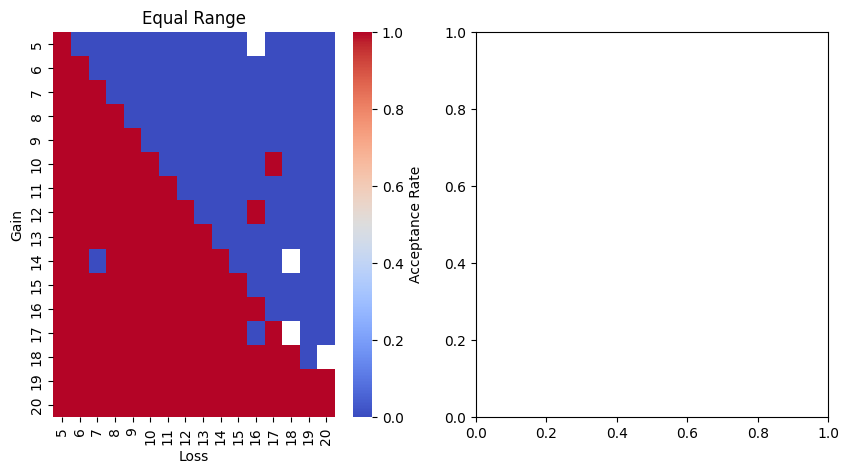

In [9]:
# Two figures: Acceptance rate per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = data.query("sub == 4").groupby(['gain', 'loss'])['accept'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Acceptance Rate'}, ax = axs[0])
axs[0].set_title("Equal Range")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

<Axes: xlabel='thing', ylabel='accept'>

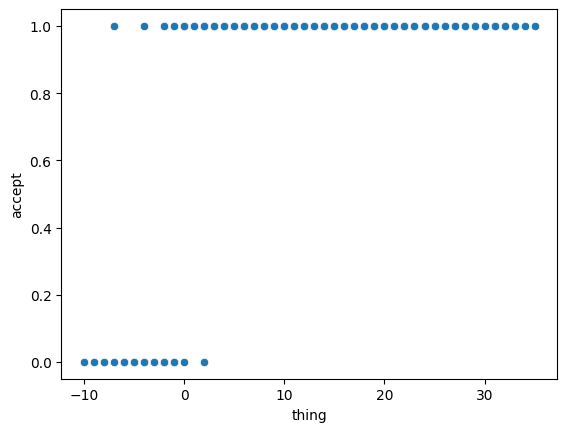

In [17]:
sns.scatterplot(data.query("sub == 11"), x = "thing", y = "accept")